In [2]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *

import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
exp_s = Experiment(
    "ERA5", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 250, None, None, None
)
da_s = exp_s.da
# exp_s_low = Experiment(
#     "ERA5", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 700, None, None, None
# )
# exp_T = Experiment(
#     "ERA5", "t", "6H", "all", "JJA", -60, 70, 25, 85, 250, 'hourofyear', {'hourofyear': ('win', 24 * 10)}, None,
# )
# da_T = exp_T.da

In [ ]:
(
    all_jets,
    where_are_jets,
    all_jets_one_array,
    all_jets_over_time,
    flags,
) = exp_s.track_jets()
flags = xr.DataArray(flags, coords=dict(time=da_s.time.values, jet=np.arange(flags.shape[1])))
props_as_ds_uncat = exp_s.props_as_ds(categorize=False)
props_as_ds_uncat = better_is_polar(all_jets, props_as_ds_uncat, exp_s_low.path)
props_as_ds = categorize_ds_jets(props_as_ds_uncat)
props_as_ds['exists'] = (~props_as_ds['mean_lon'].isnull()).astype(np.float32)

In [3]:
exp_s = Experiment(
    "ERA5", "plev", "s", "6H", (1940, 2022), "JJA", -80, 30, 20, 75
)

In [6]:
net, centers, labels = exp_s.som_cluster(
    6,
    6,
    200,
    return_type=ADJUST,
    train_kwargs=dict(train_algo="batch", epochs=400),
)

# n_samples = net.compute_populations()
# coords = net.neighborhoods.coordinates
# mask = labels_to_mask(labels)
# mask_none = mask[:, 0]
# mask = mask[:, 1:]
# center_none = centers[0]
# centers = centers[1:]
# centers_all_jets = find_all_jets(centers, height=25, cutoff_blobs=750, cutoff_jets=1200, chunksize=3)
# centers_props = compute_all_jet_props(centers_all_jets, centers)
# centers_props_ds = props_to_ds(centers_props, centers.cluster)

# bmus_da = xr.DataArray(net.bmus, coords={'time': da_s.time.values})
# labels_daily = bmus_da.interp(coords={'time': da_T.time.values}, method='nearest').astype(int).values
# mask_daily = labels_to_mask(labels_daily)
# populations = (centers.ratios.values * len(da_s.time)).astype(int)

2024-02-05 23:31:57.486 | INFO     | simpsom.network:__init__:116 - Periodic Boundary Conditions active.
2024-02-05 23:31:57.489 | INFO     | simpsom.network:__init__:127 - Hexagonal topology.
2024-02-05 23:31:57.490 | INFO     | simpsom.network:_set_weights:223 - The weights will be loaded from file


## SOM transitions

In [ ]:
yearbreaks = np.sum(bmus_da.time.dt.year == bmus_da.time.dt.year[0]).item()
possible_tuples = [
    (i, j) for i, j in product(range(net.n_nodes), range(net.n_nodes))
]
possible_tuples = np.asarray(possible_tuples, dtype='i,i')
indices = [i for n in range(len(np.unique(bmus_da.time.dt.year))) for i in range(n * yearbreaks, (n + 1) * yearbreaks - 1)]
transitions = np.zeros(len(da_s.time), dtype='i, i')
transitions[indices] = [(net.bmus[i], net.bmus[i + 1]) for i in indices]
transition_masks = transitions[:, None] == possible_tuples[None, :]
unique_transitions, counts = np.unique(transitions, return_counts=True)
trans_mat = np.zeros((net.n_nodes, net.n_nodes))
trans_mat[unique_transitions['f0'], unique_transitions['f1']] = counts
sort_order = np.argsort(counts)[::-1][:50]
sort_order_1 = [i for i in sort_order if unique_transitions[i][0] == unique_transitions[i][1]]
sort_order_2 = [i for i in sort_order if unique_transitions[i][0] != unique_transitions[i][1]]

  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:00<00:00, 203.83it/s]


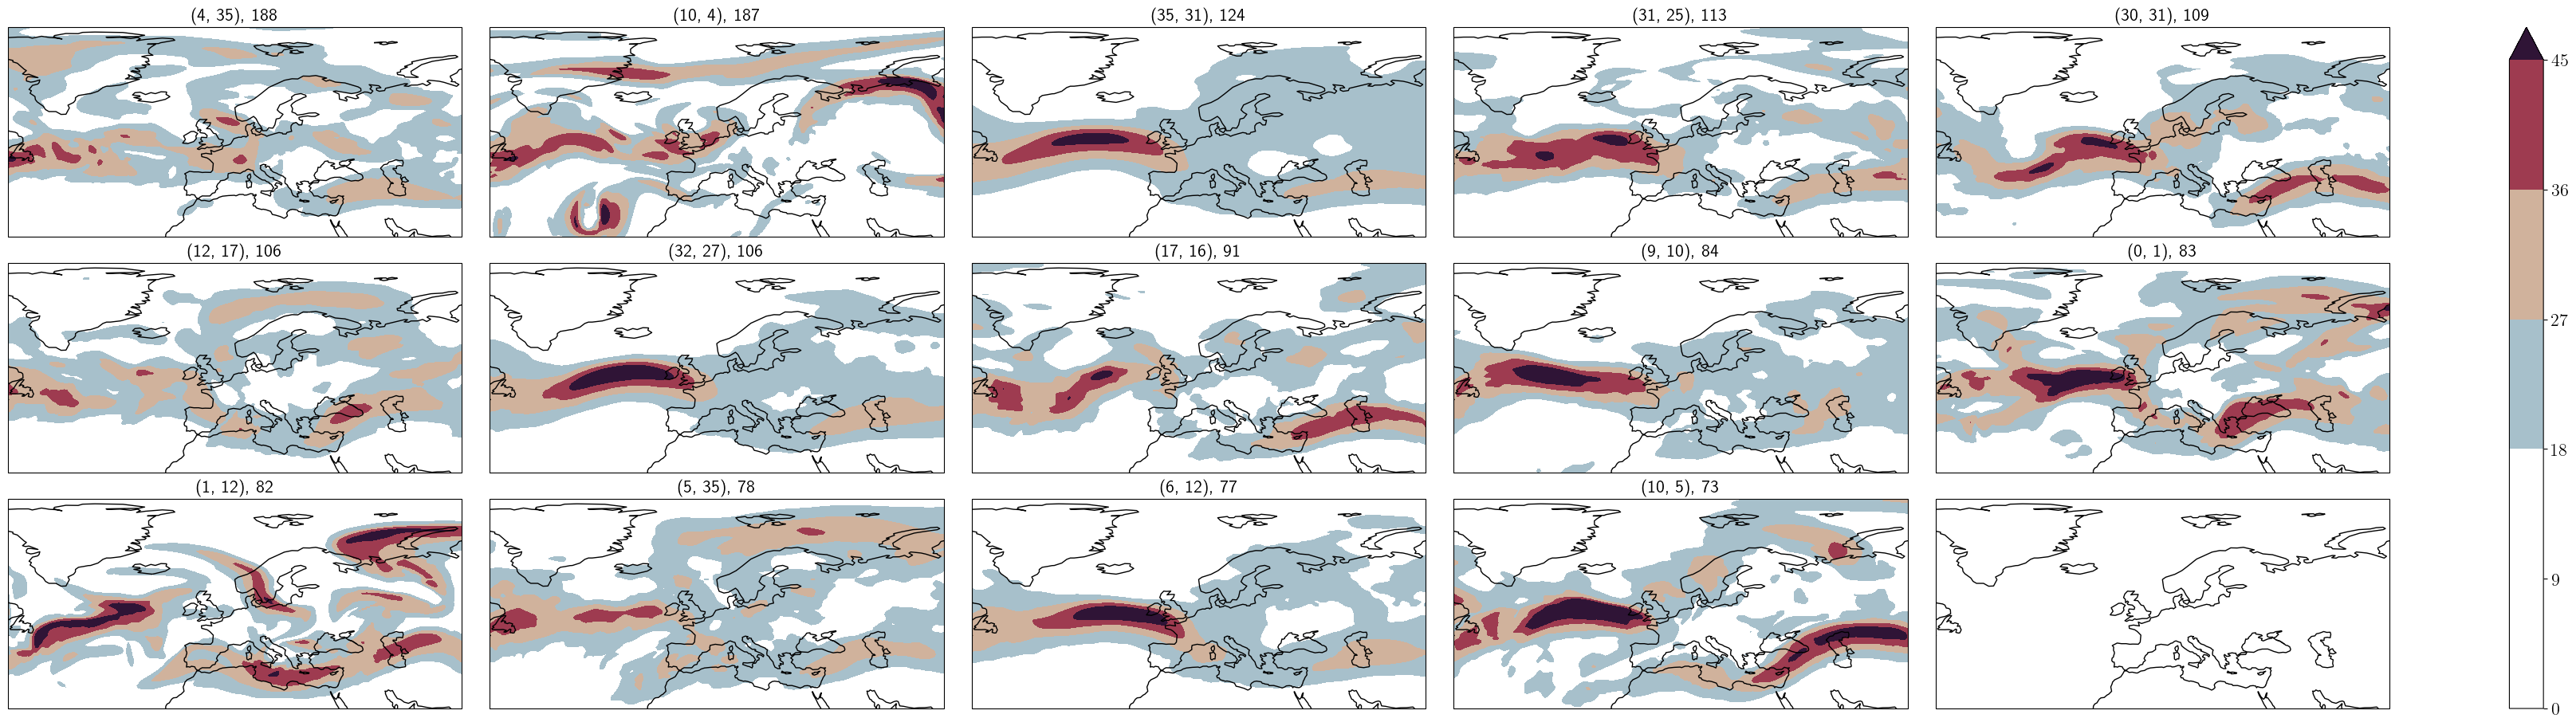

In [ ]:
import scipy.constants as co
mask_transitions = transition_masks[:, np.where(possible_tuples[:, None] == unique_transitions[None, sort_order_2])[1]]
titles = [f'{unique_transitions[i]}, {counts[i]}' for i in sort_order_2]
clu = Clusterplot(3, 5, region=exp_s.region)
_ = clu.add_any_contour_from_mask(da_s, mask_transitions, cmap='twilight_shifted', transparify=2, titles=titles)

100%|██████████| 14/14 [00:00<00:00, 202.38it/s]


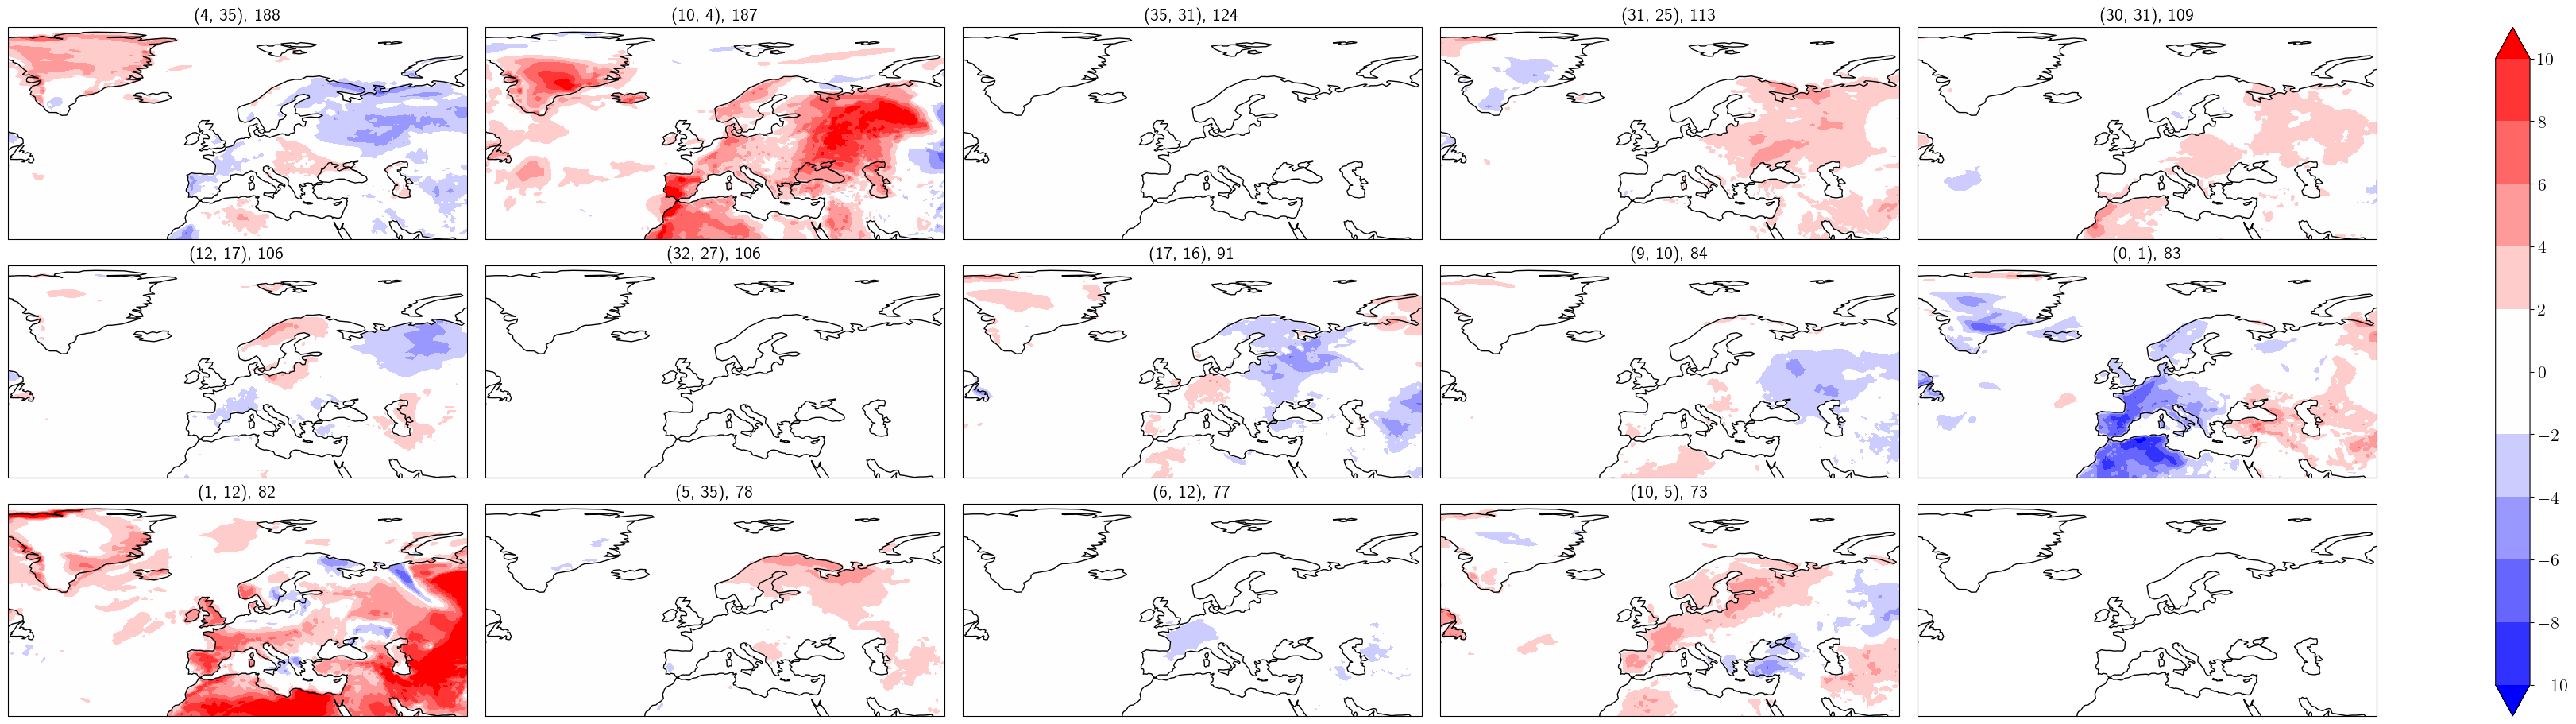

In [ ]:
import scipy.constants as co
mask_transitions = transition_masks[:, np.where(possible_tuples[:, None] == unique_transitions[None, sort_order_2])[1]]
titles = [f'{unique_transitions[i]}, {counts[i]}' for i in sort_order_2]
clu = Clusterplot(3, 5, region=exp_s.region)
_ = clu.add_any_contour_from_mask(da_T, mask_transitions, cmap='bwr', transparify=0, titles=titles)

100%|██████████| 36/36 [00:00<00:00, 416.18it/s]


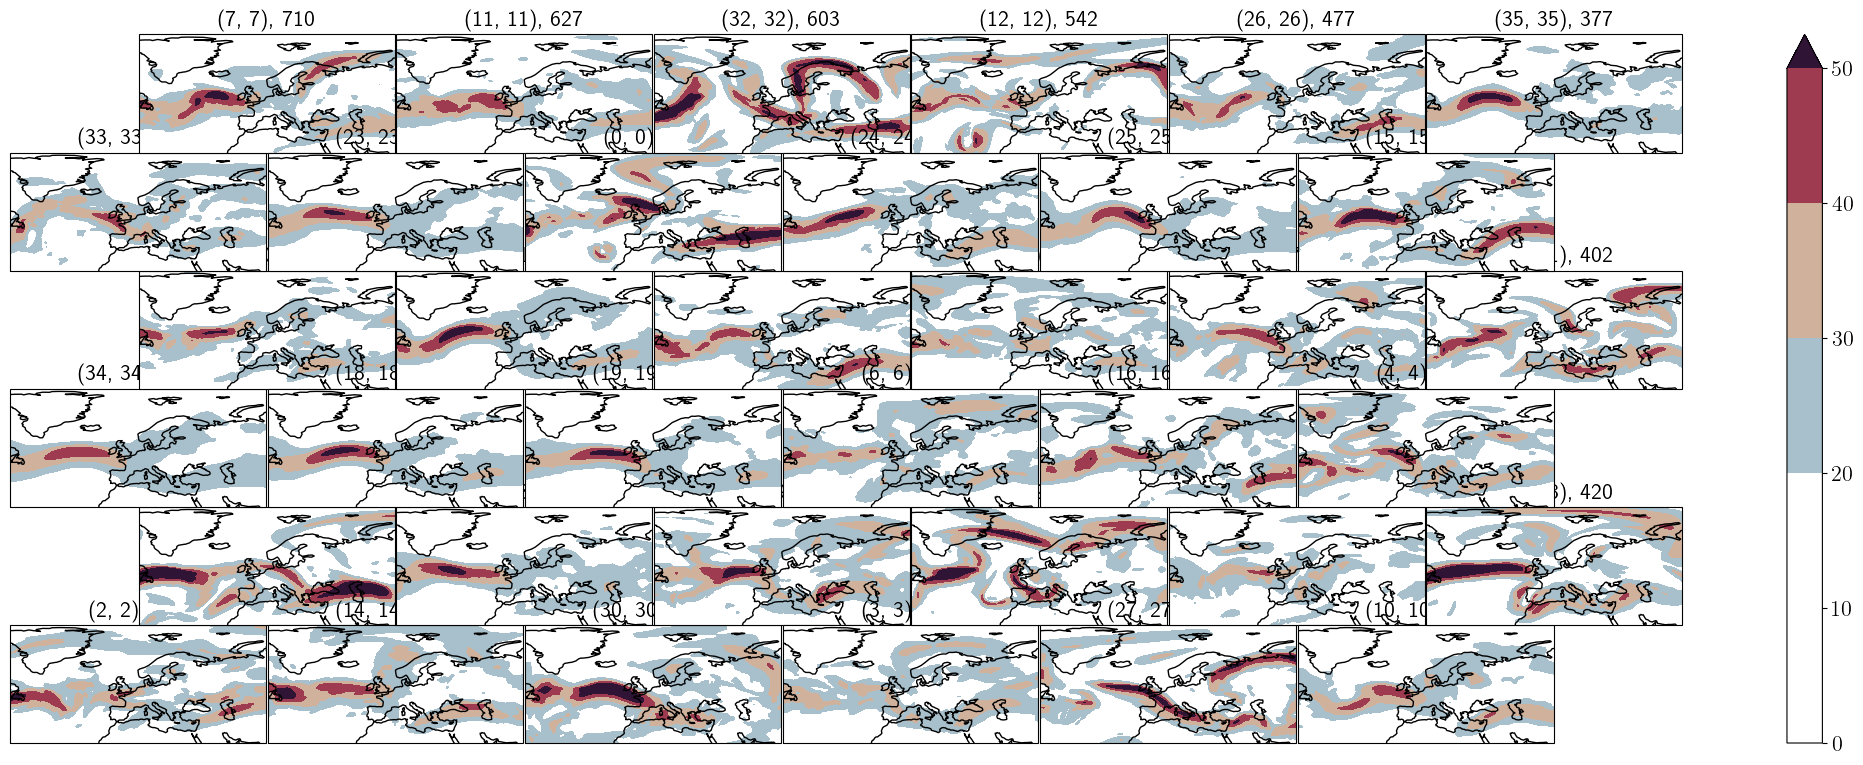

In [ ]:
import scipy.constants as co
mask_transitions = transition_masks[:, np.where(possible_tuples[:, None] == unique_transitions[None, sort_order_1])[1]]
titles = [f'{unique_transitions[i]}, {counts[i]}' for i in sort_order_1]
clu = Clusterplot(6, 6, region=exp_T.region, honeycomb=True)
_ = clu.add_any_contour_from_mask(da_s, mask_transitions, cmap='twilight_shifted', transparify=2, titles=titles)

100%|██████████| 36/36 [00:00<00:00, 419.05it/s]


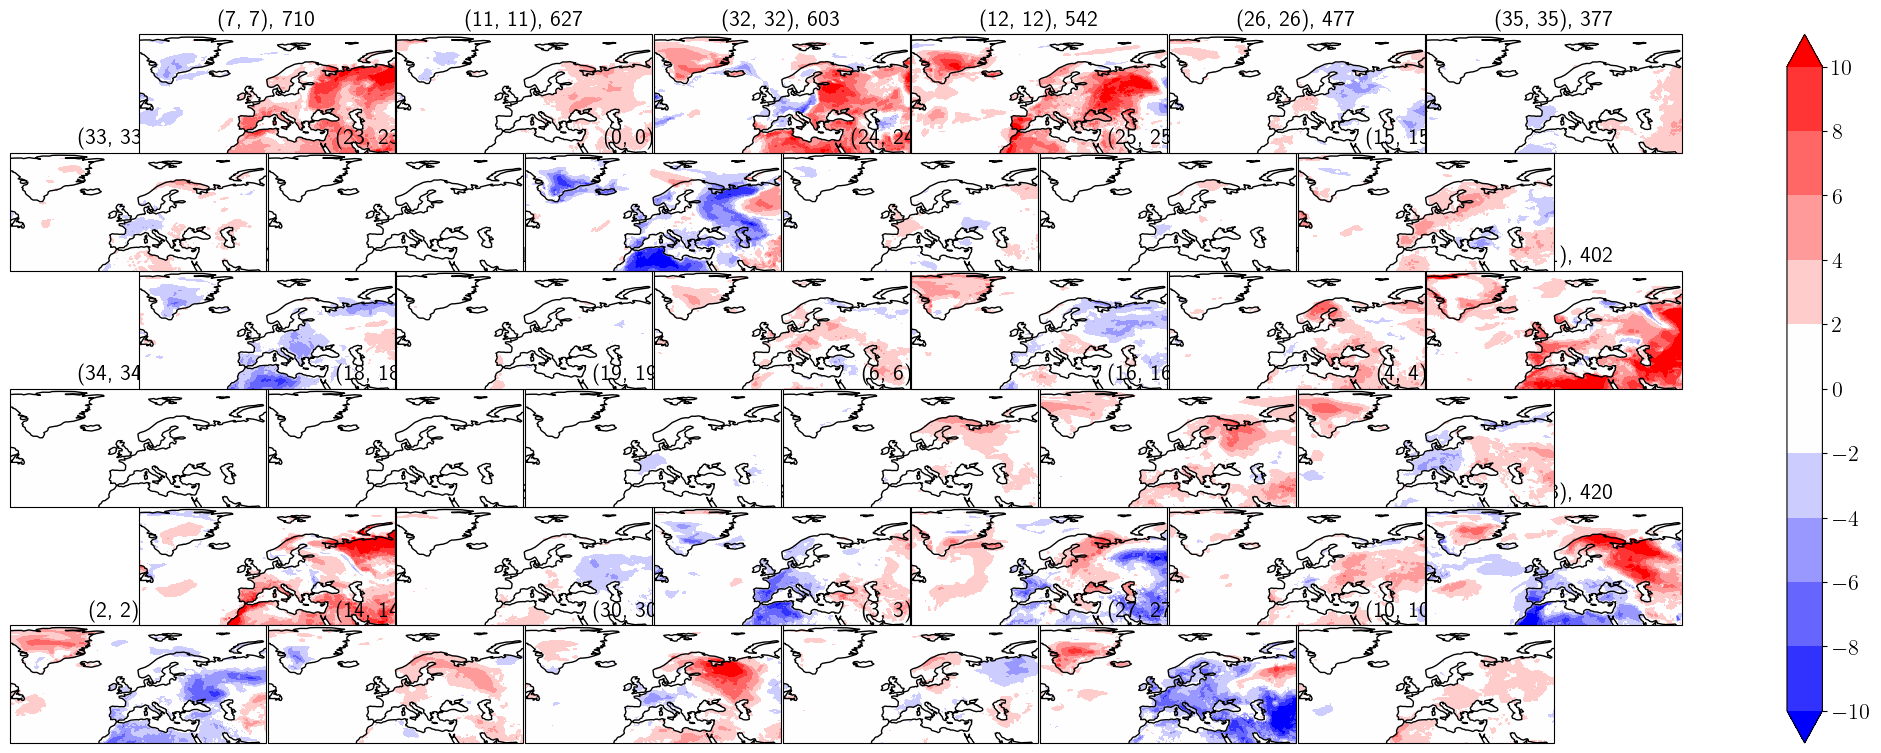

In [ ]:
import scipy.constants as co
mask_transitions = transition_masks[:, np.where(possible_tuples[:, None] == unique_transitions[None, sort_order_1])[1]]
titles = [f'{unique_transitions[i]}, {counts[i]}' for i in sort_order_1]
clu = Clusterplot(6, 6, region=exp_T.region, honeycomb=True)
_ = clu.add_any_contour_from_mask(da_T, mask_transitions, cmap='bwr', transparify=0, titles=titles)

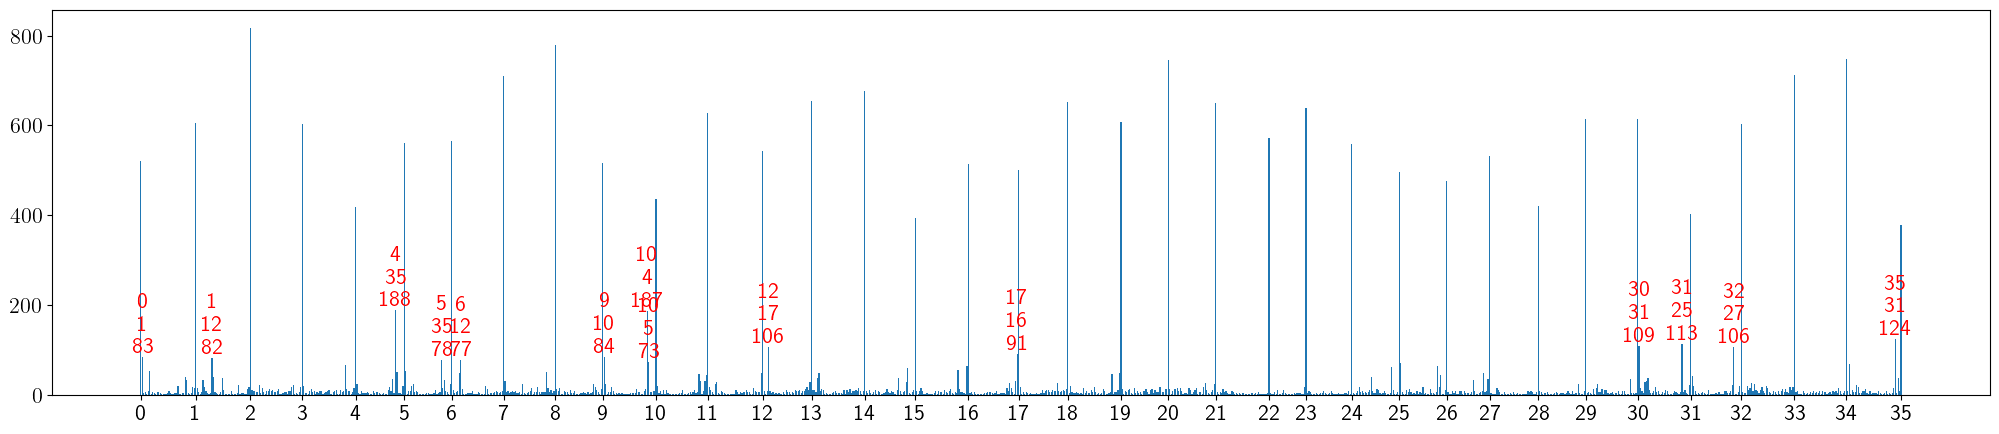

In [ ]:
fig, ax = plt.subplots(figsize=(25, 5))
ax.bar(np.arange(len(counts)), counts)
ax.set_xticks(sort_order_1, unique_transitions['f0'][sort_order_1])
for i in sort_order_2:
    xy = (i, counts[i])
    xytext = (i, counts[i])
    plt.annotate(f'{unique_transitions[i][0]} \n {unique_transitions[i][1]} \n {counts[i]}', xy=xy, xytext=xytext, ha='center', va='bottom', color='red')

In [ ]:
transitions

array([(27,  7), ( 7,  7), ( 7,  7), ..., (20, 20), (20, 14), (14, 14)],
      dtype=[('f0', '<i4'), ('f1', '<i4')])

## measures of persistence

In [ ]:
try:
    ld = xr.open_dataarray(exp_s.path.joinpath('ld.nc'))
    theta = xr.open_dataarray(exp_s.path.joinpath('theta.nc'))
except FileNotFoundError:
    from CDSK import dynamical_local_indexes

    ld = overlaps.copy(data=np.zeros_like(overlaps))
    theta = ld.copy()
    for year in tqdm(YEARSPL_EXT):
        year_mask = DATERANGEPL_EXT_6H_SUMMER.year == year
        X = da_s[year_mask].values.reshape(np.sum(year_mask), -1)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            ld_, theta_, _ = dynamical_local_indexes(X, n_jobs=2)
        ld[year_mask], theta[year_mask] = ld_.squeeze(), theta_.squeeze()
    ld.to_netcdf(exp_s.path.joinpath('ld.nc'))
    theta.to_netcdf(exp_s.path.joinpath('theta.nc'))

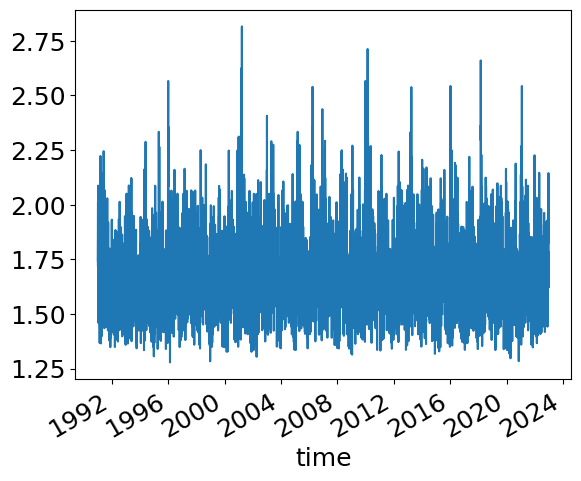

In [ ]:
from CDSK import dynamical_local_indexes
X_pca = xr.open_dataarray('/storage/scratch/users/hb22g102/ERA5/s/6H/results/pca_250hPa_fulltime.nc')
year_mask = X_pca.time.dt.year > 1990
time_mask = (X_pca.time.dt.hour == 12) & year_mask
ld, theta, _ = dynamical_local_indexes(X_pca.sel(time=time_mask, pca=np.arange(10)).values, n_jobs=10)

ld = xr.DataArray(ld.squeeze(), coords={'time': X_pca.time[time_mask].values})
thetainv = xr.DataArray(1 / theta.squeeze(), coords={'time': X_pca.time[time_mask].values})

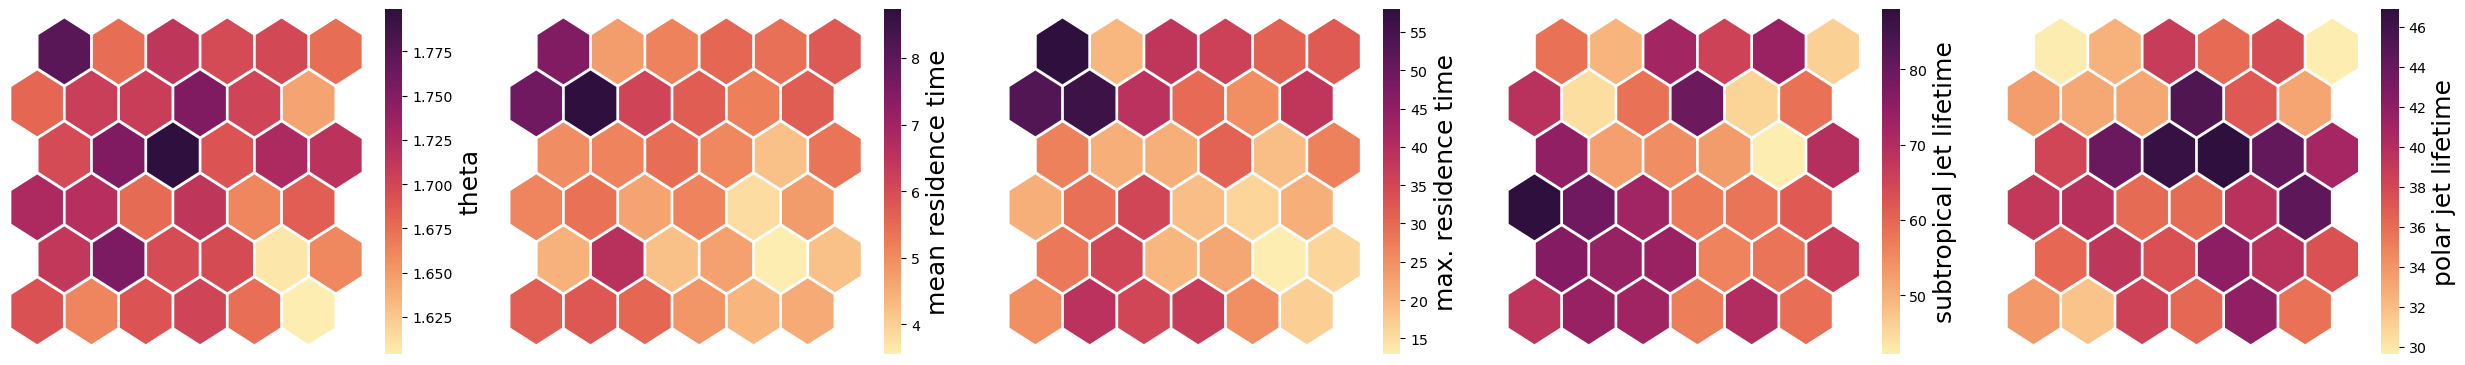

In [ ]:
summer_submask = time_mask.time.dt.season=='JJA'
theta_on_map = timeseries_on_map(thetainv.sel(time=summer_submask[time_mask]), net.bmus[time_mask[summer_submask].values])[0]
rt_mean, rt_max, rt_trend = net.compute_residence_time(0.0)
mean_jet_pers = np.asarray(
    [[props_as_ds['persistence'].sel(jet=jet)[mas].mean().values for mas in mask.T] for jet in props_as_ds.jet]
)
to_plot = {
    'theta': theta_on_map, 
    'mean residence time': rt_mean, 
    'max. residence time': rt_max, 
    'subtropical jet lifetime' : mean_jet_pers[0],
    'polar jet lifetime' : mean_jet_pers[1],
}
fig, axes = plt.subplots(1, len(to_plot), figsize=(5 * len(to_plot), 4), tight_layout=True)
for ax, (varname, quantity) in zip(axes, to_plot.items()):
    fig, ax = net.plot_on_map(
        quantity,
        show=False,
        cmap=colormaps.matter,
        cbar_label=varname,
        fig=fig,
        ax=ax,
    )

## rt, multi

In [ ]:
da = da_s
df = pd.read_csv(f"{DATADIR}/ERA5/daily_nao.csv", delimiter=",")
index = pd.to_datetime(df.iloc[:, :3])
series = xr.DataArray(df.iloc[:, 3].values, coords={"time": index})
nao_summer = series.interp_like(da_s)
nao_on_map = timeseries_on_map(nao_summer, net.bmus)[0]

net_mask_da = xr.DataArray(
    mask, coords={"time": da.time.values, "cluster": np.arange(net.n_nodes)}
)
yearly = net_mask_da.resample(time="1Y").sum().values
populations = np.sum(yearly, axis=0)
trends = np.zeros(net.n_nodes)
for k, yearly_ in enumerate(yearly.T):
    trends[k] = np.polyfit(
        np.arange(yearly.shape[0])[yearly_ != 0], yearly_[yearly_ != 0], deg=1
    )[0]


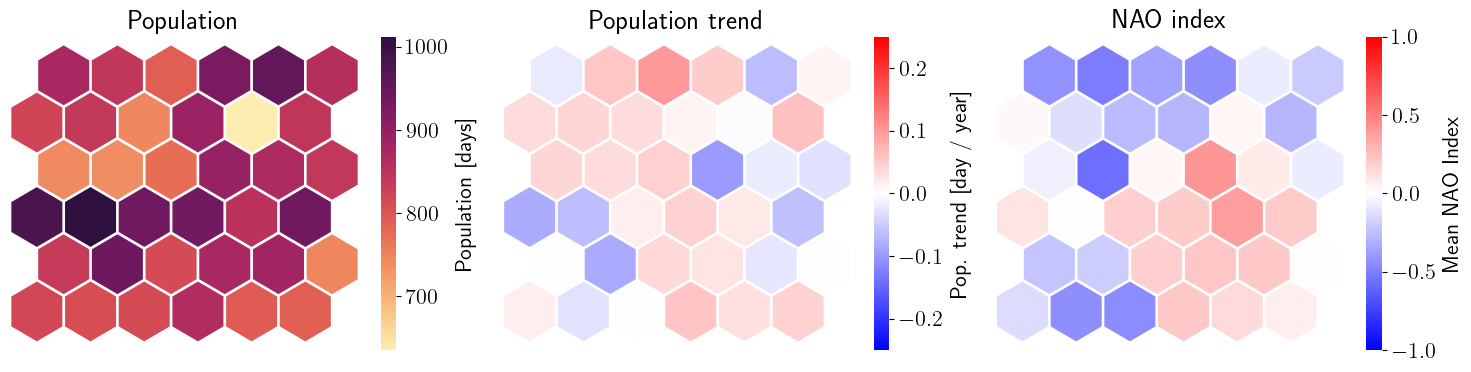

In [ ]:
cmap = colormaps.matter
fig, axes = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)
axes = axes.ravel()
fig, axes[0] = net.plot_on_map(
    populations,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    cbar_label="Population [days]",
    fig=fig,
    ax=axes[0],
    fonzsize=mpl.rcParams["font.size"],
)
axes[0].set_title("Population")
fig, axes[1] = net.plot_on_map(
    trends,
    smooth_sigma=0,
    show=False,
    cmap="bwr",
    cbar_label="Pop. trend [day / year]",
    norm=Normalize(-0.25, 0.25),
    fig=fig,
    ax=axes[1],
    fonzsize=mpl.rcParams["font.size"],
)
axes[1].set_title("Population trend")
fig, axes[2] = net.plot_on_map(
    nao_on_map,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=axes[2],
    cmap="bwr",
    cbar_label="Mean NAO Index",
    norm=Normalize(-1.0, 1.0),
    fonzsize=mpl.rcParams["font.size"],
)
axes[2].set_title("NAO index")
fig.savefig(f'{FIGURES}/som_props/pop_trend_nao.png')

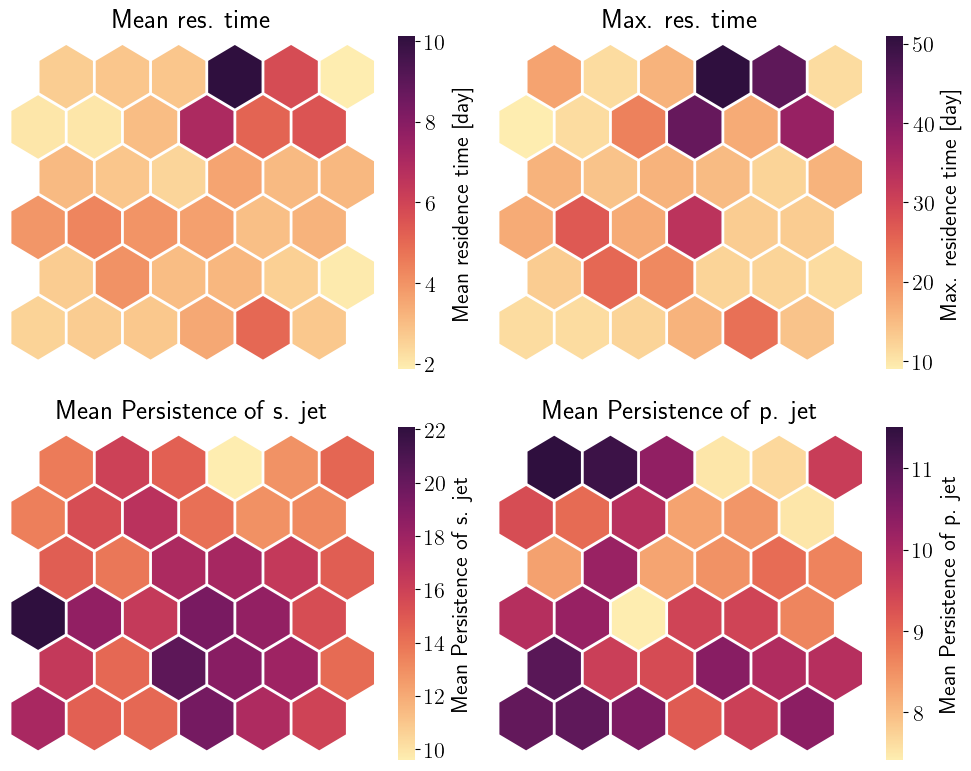

In [ ]:
rt_mean, rt_max, rt_trend = net.compute_residence_time(0.0)
persistence_subtropical = np.asarray(
    [props_as_ds['persistence'].sel(jet='subtropical')[mask_].mean().values for mask_ in mask.T]
)
persistence_polar = np.asarray(
    [props_as_ds['persistence'].sel(jet='polar')[mask_].mean().values for mask_ in mask.T]
)
cmap = colormaps.matter
fig, axes = plt.subplots(2, 2, figsize=(10, 8), tight_layout=True)
fig, axes[0, 0] = net.plot_on_map(
    rt_mean,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=axes[0, 0],
    cmap=cmap,
    cbar_label="Mean residence time [day]",
    fonzsize=mpl.rcParams["font.size"],
)
axes[0, 0].set_title("Mean res. time")
fig, axes[0, 1] = net.plot_on_map(
    rt_max,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=axes[0, 1],
    cmap=cmap,
    cbar_label="Max. residence time [day]",
    fonzsize=mpl.rcParams["font.size"],
)
axes[0, 1].set_title("Max. res. time")
fig, axes[1, 0] = net.plot_on_map(
    persistence_subtropical,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=axes[1, 0],
    cmap=cmap,
    cbar_label="Mean Persistence of s. jet",
    fonzsize=mpl.rcParams["font.size"],
)
axes[1, 0].set_title("Mean Persistence of s. jet")
fig, axes[1, 1] = net.plot_on_map(
    persistence_polar,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=axes[1, 1],
    cmap=cmap,
    cbar_label="Mean Persistence of p. jet",
    fonzsize=mpl.rcParams["font.size"],
)
axes[1, 1].set_title("Mean Persistence of p. jet")
fig.savefig(f'{FIGURES}/som_props/persistence_metrics.png')

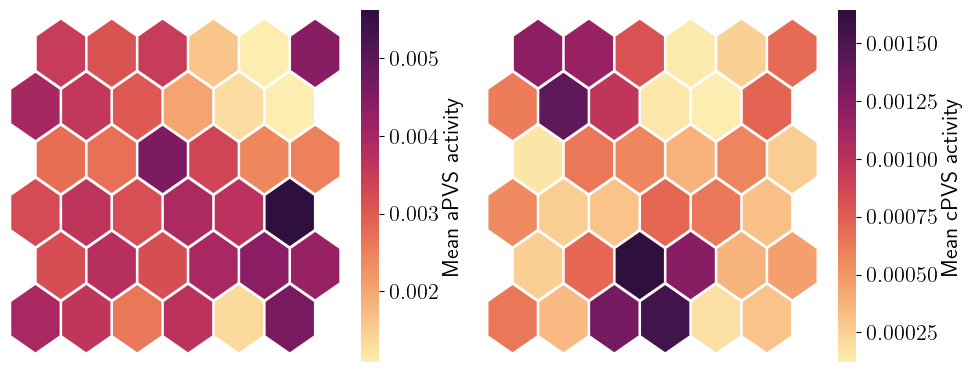

In [ ]:
to_plot_anti = np.asarray([ds_pvs['anti'][mask_[6992:]].mean().item() for mask_ in mask.T])
to_plot_cycl = np.asarray([ds_pvs['cycl'][mask_[6992:]].mean().item() for mask_ in mask.T])

cmap = colormaps.matter
fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
fig, axes[0] = net.plot_on_map(
    to_plot_anti,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[0],
    cbar_label="Mean aPVS activity",
)

fig, axes[1] = net.plot_on_map(
    to_plot_cycl,
    smooth_sigma=0,
    fig=fig,
    cmap=cmap,
    ax=axes[1],
    cbar_label="Mean cPVS activity",
)
fig.savefig(f'{FIGURES}/som_props/PVS_activity.png')

## jet indices

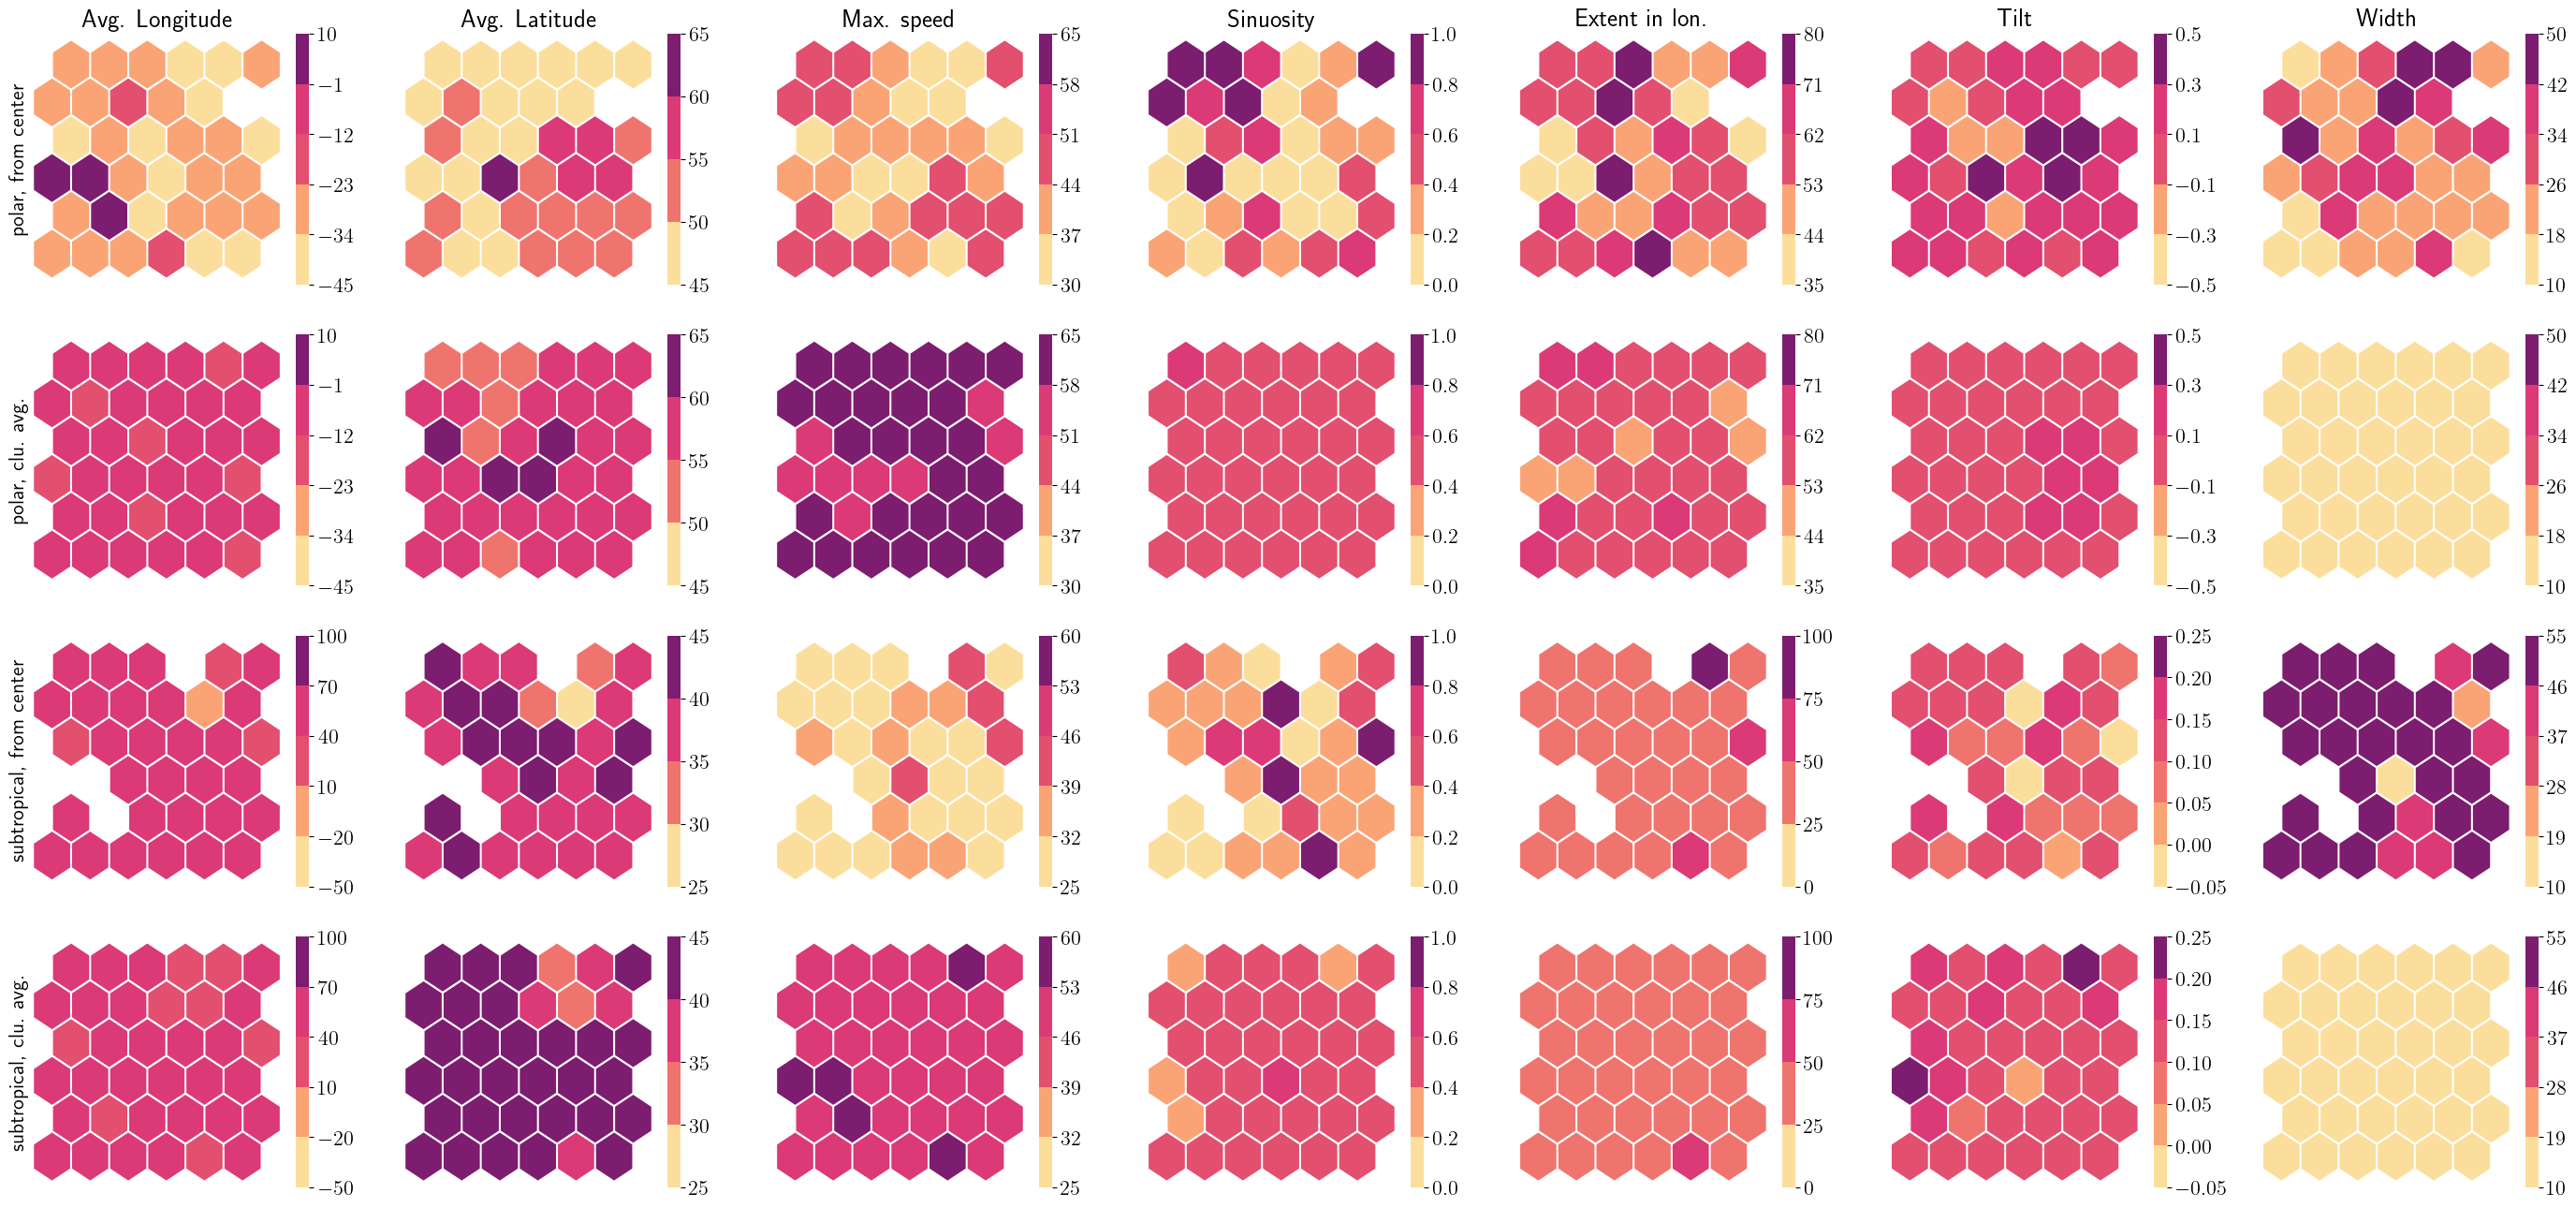

In [ ]:
# both at once : is the som jet-prop preserving ? Probably not heh
varnames_subset = ["mean_lon", "mean_lat", "Spe", "sinuosity", "lon_ext", "tilt", "width"]

centers_props_ds_catd = categorize_ds_jets(centers_props_ds)
kwargs = {"cmap": cmaps.sunsetdark}
fig, axes = plt.subplots(
    4, len(varnames_subset), figsize=(5 * len(varnames_subset), 16)
)
sub_title = ['from center', 'clu. avg.']
for k, varname in enumerate(varnames_subset):
    axes[0, k].set_title(PRETTIER_VARNAME[varname])
    for j, jet in enumerate(['polar', 'subtropical']):
        to_plot1 = np.asarray(
            [
                centers_props_ds_catd[varname].sel(jet=jet, cluster=k).mean().values
                for k in range(net.n_nodes)
            ]
        )
        to_plot2 = np.asarray(
            [props_as_ds[varname].sel(jet=jet)[mas].mean().values for mas in mask.T]
        )
        mini, maxi = np.nanmin([to_plot1, to_plot2]), np.nanmax([to_plot1, to_plot2])
        levels = create_levels([to_plot1, to_plot2], sym=False)[0]
        kwargs['norm'] = BoundaryNorm(levels, kwargs['cmap'].N)
        ax = axes[2 * j, k]
        fig, ax = net.plot_on_map(
            to_plot1,
            smooth_sigma=0,
            show=False,
            fig=fig,
            ax=ax,
            draw_cbar=True,
            **kwargs,
        )
        ax = axes[2 * j + 1, k]
        fig, ax = net.plot_on_map(
            to_plot2,
            smooth_sigma=0,
            show=False,
            fig=fig,
            ax=ax,
            draw_cbar=True,
            **kwargs,
        )
        if k == 0:
            for l, ax in enumerate(axes[2 * j : 2 * j + 2, k]):
                ax.axis("on")
                ax.spines[["right", "top", "left", "bottom"]].set_visible(False)
                ax.tick_params(
                    bottom=False, left=False, labelbottom=False, labelleft=False
                )
                ax.set_ylabel(f'{jet}, {sub_title[l]}')
fig.savefig(f'{FIGURES}/som_props/jet_indices.png')